In [1]:
import json 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [52]:
bits = "4" # "8" or "4"
model_name = ["mistralai/Mixtral-8x22B-Instruct-v0.1","01-ai/Yi-1.5-9B-Chat","mistralai/Mixtral-8x7B-Instruct-v0.1","Qwen/Qwen1.5-7B-Chat","meta-llama/Meta-Llama-3-8B-Instruct"]
i = 0

results=[]
coverage_raw=[]


with open("./scripts/we_gridout_"+bits+"bit_"+"_".join(model_name[4].split("/"))+".jsonl", "r") as f:
    for idx, line in enumerate(f):
        line = json.loads(line)
        if idx%50==0:
            results.append(line)
        coverage_raw.append(len(line["aligned_output"])/len(line["truncated_input"]))

coverage_all = [[] for i in range(int(len(coverage_raw)/50)+1)]
coverage_avg = []

print(len(coverage_raw))

for i in range(int(len(coverage_raw)/50)+1):
    for j in range(50):
        try:
            coverage_all[i].append(coverage_raw[i*50+j])
        except:
            None

coverage_avg = [sum(elt)/len(elt) for elt in coverage_all]
print(coverage_raw[:100])

9688
[0.4300341296928328, 0.855072463768116, 0.975452196382429, 0.3146417445482866, 0.0009017132551848512, 1.0044510385756678, 0.6040386303775241, 0.6384839650145773, 0.5433212996389891, 0.8409785932721713, 0.5762852404643449, 0.5290697674418605, 0.9714285714285714, 0.802747791952895, 0.6578249336870027, 0.9703832752613241, 0.9154704944178629, 0.9869524697110904, 0.4444444444444444, 0.9253567508232712, 0.9556603773584905, 0.7902973395931142, 0.9843205574912892, 0.8483992467043314, 0.9400871459694989, 0.9581646423751687, 0.8426395939086294, 0.6090289608177172, 0.7522281639928698, 0.9741496598639455, 0.975, 0.6952296819787986, 0.7458333333333333, 0.8923643054277829, 1.001751313485114, 0.7109756097560975, 1.0134854771784232, 0.4918032786885246, 0.29227323628219487, 0.27953890489913547, 0.9383966244725739, 0.5395449620801733, 0.9026548672566371, 0.5185537583254044, 0.9953789279112755, 0.6519230769230769, 1.0051502145922746, 0.7712177121771218, 0.400329489291598, 0.2939068100358423, 0.89977

In [49]:
time = []
tokens = []
coverage = []
wer = []
window_size = []
do_sample=[]
beam_search=[]
num_beams=[]
temperature=[]

y = []

lowest_score = 1
lowest_score_index = 0

for index, elt in enumerate(results):
    time.append(elt["time taken"])
    tokens.append(elt["total tokens generated"])
    coverage.append(len(elt["aligned_output"])/len(elt["truncated_input"]))
    
    wer.append(elt["scores"]["hf_wer"])
    do_sample.append(elt["parameters"]["do_sample"])

    if elt["scores"]["hf_wer"] < lowest_score:
        lowest_score = elt["scores"]["hf_wer"]
        lowest_score_index = index

    try:
        beam_search.append(elt["parameters"]["beam_search"])
    except:
        beam_search.append(False)

    try:
        num_beams.append(elt["parameters"]["num_beams"])
    except:
        num_beams.append(0)
        
    try:
        temperature.append(elt["parameters"]["temperature"])
    except:
        temperature.append(0)
        
    window_size.append(elt["parameters"]["window_size"])
    y.append(elt["total tokens generated"]/elt["time taken"])

print("lowest score at index:", index)

lowest score at index: 193


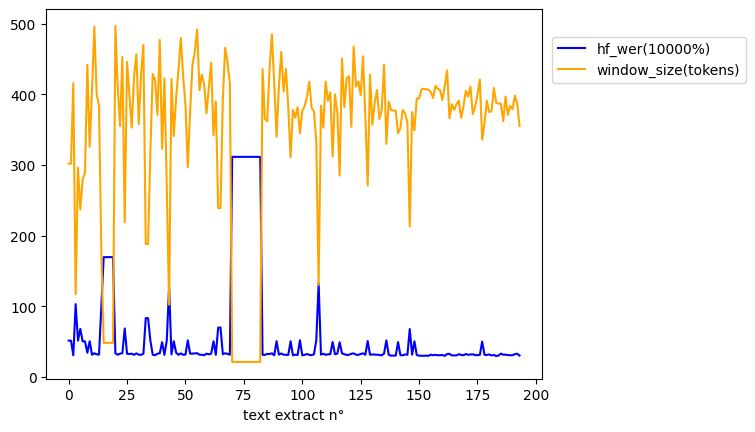

In [50]:
x = [i for i in range(len(time))]

sigma = 10 
window_size_smooth = window_size
wer_smooth =wer

plt.plot(x, [elt*1000 for elt in wer_smooth], color="blue", label="hf_wer(10000%)")
plt.plot(x, window_size_smooth, color="orange", label="window_size(tokens)")
plt.xlabel("text extract n°")
plt.legend(loc=(1.02, 0.8))
plt.show()

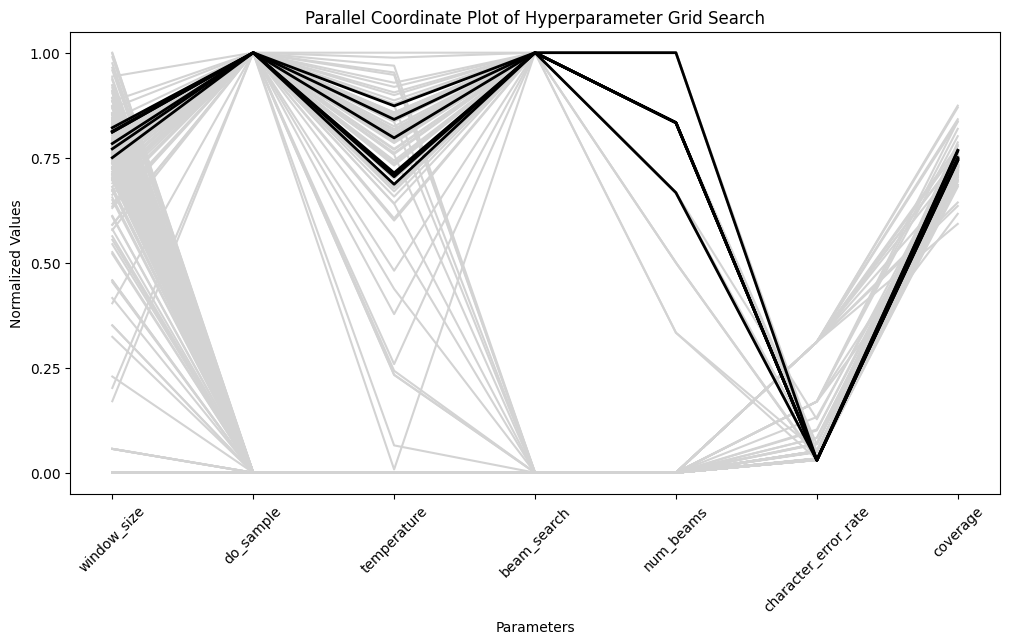

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample data representing the hyperparameter grid search results
data = {
    'window_size': window_size,
    'do_sample': do_sample,
    'temperature': temperature,
    'beam_search': beam_search,
    'num_beams': num_beams, 
    'character_error_rate': wer, 
    'coverage': coverage_avg
}

'''print(len(window_size))
print(len(do_sample))
print(len(temperature))
print(len(beam_search))
print(len(num_beams))
print(len(wer))
print(len(coverage_avg))'''

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data for plotting purposes
df_normalized = df.copy()
for column in df_normalized.columns:
    if (df_normalized[column].dtype != bool and column != 'character_error_rate') and column !='coverage':
        df_normalized[column] = (df_normalized[column] - df_normalized[column].min()) / (df_normalized[column].max() - df_normalized[column].min())

# Define a function to convert boolean to int for plotting
df_normalized['do_sample'] = df_normalized['do_sample'].astype(int)
df_normalized['beam_search'] = df_normalized['beam_search'].astype(int)

# Sort the DataFrame based on character error rate
df_sorted = df_normalized.sort_values(by='character_error_rate')

# Split the DataFrame into two parts
df_grey = df_sorted[7:]
df_black = df_sorted[:7]

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the grey lines first
for i in range(len(df_grey)):
    ax.plot(df_grey.columns, df_grey.iloc[i], color='lightgrey')

# Plot the black lines on top
for i in range(len(df_black)):
    ax.plot(df_black.columns, df_black.iloc[i], color='black', linewidth=2)

# Customize the axis labels to show actual values
for i, column in enumerate(df.columns):
    values = df[column]
    normalized_values = df_normalized[column]
    tick_positions = np.linspace(0, 1, num=5)
    tick_labels = np.linspace(0, 1, num=5)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=45)
    ax.set_yticks(tick_positions)
    ax.set_yticklabels([f"{label:.2f}" for label in tick_labels])

# Label the plot
plt.title('Parallel Coordinate Plot of Hyperparameter Grid Search')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')

plt.show()


In [34]:
print(df_black)

     window_size  do_sample  temperature  beam_search  num_beams  \
183     0.771008          1     0.873428            1   0.833333   
161     0.821429          1     0.709351            1   0.666667   
154     0.810924          1     0.704624            1   0.833333   
152     0.813025          1     0.713741            1   0.833333   
151     0.810924          1     0.686598            1   0.833333   
138     0.750000          1     0.841135            1   0.833333   
150     0.783613          1     0.797160            1   1.000000   

     character_error_rate  coverage  
183              0.029353  0.724627  
161              0.029592  0.721685  
154              0.029593  0.744457  
152              0.029643  0.742618  
151              0.029727  0.721028  
138              0.029801  0.715440  
150              0.029825  0.723847  


/usr/local/lib64/python3.9/site-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (194). n_quantiles is set to n_samples.
  warnings.warn(


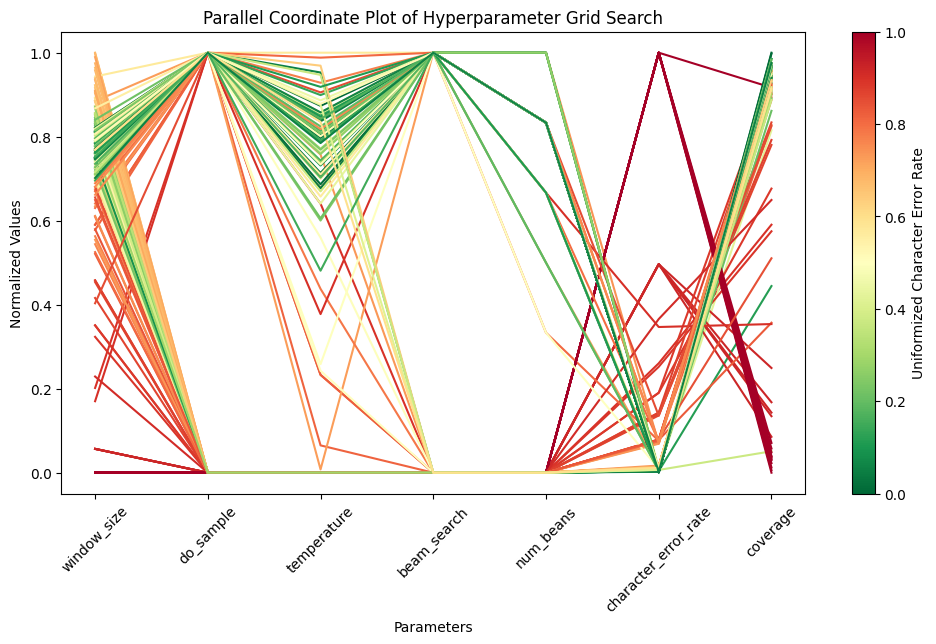

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import QuantileTransformer
import matplotlib.colors as mcolors
# Sample data representing the hyperparameter grid search results
data = {
    'window_size': window_size,
    'do_sample': do_sample,
    'temperature': temperature,
    'beam_search': beam_search,
    'num_beans': num_beams, 
    'character_error_rate': wer, 
    'coverage': coverage_avg
}


# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Normalize the data (excluding boolean columns) for better visualization
for column in df.columns:
    if df[column].dtype != bool:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

# Define a function to convert boolean to int for plotting
df_normalized['do_sample'] = df_normalized['do_sample'].astype(int)
df_normalized['beam_search'] = df_normalized['beam_search'].astype(int)


# Use QuantileTransformer to normalize the character error rate
quantile_transformer = QuantileTransformer(output_distribution='uniform')
df['character_error_rate_normalized'] = quantile_transformer.fit_transform(df[['character_error_rate']])

# Determine the colors based on the normalized character error rate
norm = plt.Normalize(df['character_error_rate_normalized'].min(), df['character_error_rate_normalized'].max())
colors = plt.cm.RdYlGn_r(norm(df['character_error_rate_normalized']))

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the parallel coordinates
for i in range(len(df)):
    ax.plot(df.columns[:-1], df.iloc[i, :-1], color=colors[i])

# Add colorbar for reference
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Uniformized Character Error Rate')

# Label the axes
plt.xticks(rotation=45)
plt.title('Parallel Coordinate Plot of Hyperparameter Grid Search')
plt.xlabel('Parameters')
plt.ylabel('Normalized Values')

plt.show()
